In [1]:
from PIL import ImageFont, ImageDraw, Image
from fontTools.ttLib import TTFont
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import multiprocessing

In [2]:
VOCAB = 28; MAX_LEN = 5; MAX_DUP = 6
EBD_DIM = 256; UNIT_DIM = 128; BATCH_SIZE = 256

## Load Font

In [3]:
class Glyph(object):
    # transform character to bitmap
    def __init__(self, fonts, size=64):
        # load fonts, size. We will use 2 fonts for all CJK characters, so keep 2 codepoint books.
        self.codepoints = [set() for _ in fonts]
        self.size = int(size * 0.8)
        self.size_img = size
        self.pad = (size - self.size) // 2
        self.fonts = [ImageFont.truetype(f, self.size) for f in fonts]
        # use a cache to reduce computation if duplicated characters encountered.
        self.cache = {}
        for cp, font in zip(self.codepoints, fonts):
            font = TTFont(font)
            # store codepoints in font cmap into self.codepoints
            for cmap in font['cmap'].tables:
                if not cmap.isUnicode():
                    continue
                for k in cmap.cmap:
                    cp.add(k)
    
    def draw(self, ch):
        if ch in self.cache:
            return self.cache[ch]
        # search among fonts, use the first found
        exist = False
        for i in range(len(self.codepoints)):
            if ord(ch) in self.codepoints[i]:
                font = self.fonts[i]
                exist = True
                break
        if not exist:
            return None

        img = Image.new('L', (self.size_img, self.size_img), 0)
        draw = ImageDraw.Draw(img)
        (width, baseline), (offset_x, offset_y) = font.font.getsize(ch)
        draw.text((self.pad - offset_x, self.pad - offset_y + 4), ch, font=font, fill=255, stroke_fill=255) 
        img_array = np.array(img.getdata(), dtype='float32').reshape((self.size_img, self.size_img)) / 255
        self.cache[ch] = img_array

        return img_array

In [4]:
glyphbook = Glyph(['data/fonts/HanaMinA.otf', 'data/fonts/HanaMinB.otf'])

In [5]:
def _mapping(item):
    char, code, dup_total, dup_curr = item
    glyph = glyphbook.draw(char)
    if glyph is not None:
        return glyph, code, dup_total, dup_curr

def preprocess_chart(chart, cores=multiprocessing.cpu_count()):
    glyphs = []; codes = []
    dup_total = []; dup_curr = []
    with multiprocessing.Pool(processes=cores) as pool:
        for item in pool.map(_mapping, chart.values):
            if item is not None:
                glyphs.append(item[0])
                codes.append(item[1])
                dup_total.append(item[2])
                dup_curr.append(item[3])
    return np.expand_dims(np.array(glyphs), -1), np.array(codes), np.array(dup_total), np.array(dup_curr)

In [6]:
def tokenizer(code_table):
    # Cangjie code consists only of a-z, with maximum length of 5, minimum of 1
    # start with 0, a-z are 1-26, end and padding are 27
    tokens = np.expand_dims(np.zeros(code_table.shape, dtype='int64'), -1)
    code_index = list(map(lambda x: list(map(lambda y: ord(y) - 96, list(x))) + [27] * (5-len(x)), code_table))
    tokens = np.append(tokens, np.array(code_index), axis=-1)
    return tokens

In [7]:
code_chart = pd.read_csv('data/cangjie6.txt', delimiter='\t', header=None, names=['Char', 'Code'], keep_default_na=False)

In [8]:
count = {}
for char, code in code_chart.values:
    if char in count:
        count[char].append(code)
        count[char].sort(key=len)
        count[char].sort(key=lambda x: (len(x), x))
    else:
        count[char] = [code]

In [9]:
code_chart['DuplicateTotal'] = code_chart['Char'].map(count).map(len).copy()
code_chart['DuplicateCurrent'] = code_chart.apply(lambda x: count[x['Char']].index(x['Code']) + 1, axis=1).copy()

In [10]:
glyphs, codes, dups_total, dups_curr = preprocess_chart(code_chart)
tokens = tokenizer(codes)
lengths = np.array([len(list(filter(lambda i: i < VOCAB - 1 and i > 0, x))) for x in tokens])
lengths = np.array([np.identity(MAX_LEN)[i-1] for i in lengths], dtype='int64')
dups_total = np.array([np.identity(MAX_DUP)[i-1] for i in dups_total], dtype='int64')
dups_curr = np.array([np.identity(MAX_DUP)[i-1] for i in dups_curr], dtype='int64')
del code_chart, codes, count

In [11]:
(train_glyphs, validation_glyphs,
 train_tokens, validation_tokens,
 train_lengths, validation_lengths,
 train_dups_total, validation_dups_total,
 train_dups_curr, validation_dups_curr) = train_test_split(
    glyphs, tokens, lengths, dups_total, dups_curr, test_size=0.1, random_state=1225)
del glyphs, tokens, lengths, dups_total, dups_curr

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((train_glyphs, train_tokens, train_lengths, train_dups_total, train_dups_curr))
dataset = dataset.shuffle(train_glyphs.shape[0]).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((validation_glyphs, validation_tokens, validation_lengths, validation_dups_total, validation_dups_curr))
val_dataset = val_dataset.shuffle(validation_glyphs.shape[0]).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

del train_glyphs, validation_glyphs, train_tokens, validation_tokens, train_lengths, validation_lengths
del train_dups_total, validation_dups_total, train_dups_curr, validation_dups_curr

## Model

In [13]:
class Res_CNN(tf.keras.Model):
    def __init__(self, feature_dim, kernel_size):
        super(Res_CNN, self).__init__()
        self.cnn1 = tf.keras.layers.Convolution2D(feature_dim, kernel_size, padding='same')
        self.cnn2 = tf.keras.layers.Convolution2D(feature_dim, kernel_size, padding='same')
        self.cnn3 = tf.keras.layers.Convolution2D(feature_dim, kernel_size, padding='same')
        self.norm = tf.keras.layers.BatchNormalization()
        
    def call(self, x):
        x = self.cnn1(x)
        x_identity = tf.identity(x)
        x = self.cnn2(x)
        x_identity2 = tf.identity(x)
        x = self.cnn3(x + x_identity)
        x = self.norm(x + x_identity2)
        x = tf.nn.relu(x)
        return x

In [14]:
class CNN_Encoder(tf.keras.Model):
    # This is essentially a CNN layer, 
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.res_cnn1 = Res_CNN(embedding_dim // 16, (3, 3))
        self.pool1 = tf.keras.layers.MaxPool2D((2, 2))
        self.res_cnn2 = Res_CNN(embedding_dim // 4, (3, 3))
        self.pool2 = tf.keras.layers.MaxPool2D((2, 2))
        self.res_cnn3 = Res_CNN(embedding_dim, (3, 3))
        self.fc = tf.keras.layers.Dense(embedding_dim, activation='relu')

    def call(self, x, training=True):
        # x shape after cnn1 == (batch_size, 64, 64, embedding_dim // 16)
        x = self.res_cnn1(x)
        # x shape after pool1 == (batch_size, 32, 32, embedding_dim // 16)
        x = self.pool1(x)
        
        # x shape after cnn2 == (batch_size, 32, 32, embedding_dim // 4)
        x = self.res_cnn2(x)
        # x shape after pool2 == (batch_size, 16, 16, embedding_dim // 4)
        x = self.pool2(x)
        
        # x shape after cnn3 == (batch_size, 16, 16, embedding_dim)
        x = self.res_cnn3(x)
        # reshape from (batch_size, 16, 16, embedding_dim) to (batch_size, 256, embedding_dim)
        x = tf.reshape(x, [x.shape[0], -1, x.shape[-1]])
        # x shape after fc == (batch_size, 256, embedding_dim)
        if training:
            x = tf.nn.dropout(x, rate=0.4)
        x = self.fc(x)
        return x

In [15]:
class Bahdanau_Attention(tf.keras.Model):
    def __init__(self, attention_dim):
        super(Bahdanau_Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(attention_dim)
        self.W2 = tf.keras.layers.Dense(attention_dim)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_Encoder output) shape == (batch_size, 256, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 256, attention_dim)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 256, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, embedding_dim)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [16]:
class Length_Decoder(tf.keras.Model):
    def __init__(self, max_length):
        super(Length_Decoder, self).__init__()
        self.pool = tf.keras.layers.MaxPool2D((2, 2))
        self.fc1 = tf.keras.layers.Dense(max_length * 16, activation='relu')
        self.fc2 = tf.keras.layers.Dense(max_length * 16, activation='relu')
        self.fc3 = tf.keras.layers.Dense(max_length * 4, activation='relu')
        self.fc4 = tf.keras.layers.Dense(max_length)
        
    def call(self, x, d_t=None, d_c=None):
        x = tf.reshape(x, (x.shape[0], 16, 16, x.shape[-1]))
        x = self.pool(x) # shape = (batch_size, 8, 8, embedding_dim)
        x = self.fc1(x)
        x = tf.reshape(x, (x.shape[0], -1))
        if d_t != None and d_c != None:
            d = tf.concat([tf.cast(d_t, 'float32'), tf.cast(d_c, 'float32')], axis=-1)
            x = tf.concat([d, x], axis=-1)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        # shape = (batch_size, max_length)
        return x

In [17]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, hidden_size, vocab_size, max_length):
        super(RNN_Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru1 = tf.keras.layers.GRU(self.hidden_size, return_sequences=True,
                                        return_state=True, recurrent_initializer='glorot_uniform', dropout=0.3)
        self.gru2 = tf.keras.layers.GRU(self.hidden_size, return_sequences=True,
                                        return_state=True, recurrent_initializer='glorot_uniform')
        self.gru3 = tf.keras.layers.GRU(self.hidden_size, return_sequences=True,
                                        return_state=True, recurrent_initializer='glorot_uniform', dropout=0.3)
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = Bahdanau_Attention(hidden_size)

    def call(self, x, l, d_t, d_c, features, hidden, training=True, teacher_forcing=True):
        # x is forward direction, y is beckward direction
        # defining attention as a separate model
        l = tf.cast(l, 'float32')
        hidden_0_with_length = tf.concat([l, hidden[0]], axis=-1)
        context_vector, attention_weights = self.attention(features, hidden_0_with_length)
        l = tf.expand_dims(l, 1)
        d = tf.expand_dims(tf.concat([tf.cast(d_t, 'float32'), tf.cast(d_c, 'float32')], axis=-1), 1)

        # x shape before is (batch_size, 1) since it is passed through one by one at a time
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        if teacher_forcing:
            x = self.embedding(x)
        else:
            if not self.embedding.built:
                self.embedding(x)
            x = tf.tensordot(x, self.embedding.weights[0], axes=[-1,0])
        # context_vector shape is (batch_size, embedding_dim)
        # x shape after concatenation == (batch_size, 1, embedding_dim + embedding_dim)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        # x shape is (batch_size, 1, hidden_size)
        # state is new hidden used in next step
        x, state1 = self.gru1(x, initial_state = hidden[0], training=training)
        x_identity = tf.identity(x)
        x = tf.concat([d, l, x], axis=-1)
        x, state2 = self.gru2(x, initial_state = hidden[1], training=training)
        x_identity2 = tf.identity(x)
        x, state3 = self.gru3(x + x_identity, initial_state = hidden[2], training=training)
        # x shape (batch_size, 1, max_length + hidden_size)
        x = tf.concat([d, l, x + x_identity2], axis=-1)
        x = tf.reshape(x, (x.shape[0], -1))
        # x shape (batch_size, hidden_size)
        x = self.fc1(x)
        # x shape (batch_size, vocab_size)
        x = self.fc2(x)

        return x, [state1, state2, state3], attention_weights

    def reset_state(self, batch_size):
        # generate new hidden layer with different batch size
        return [tf.zeros((batch_size, self.hidden_size)) for _ in range(3)]

## Load Model

In [18]:
optimizer = tf.keras.optimizers.Adam()
optimizer_length = tf.keras.optimizers.Adam()
optimizer_dups = tf.keras.optimizers.Adam()

In [19]:
encoder = CNN_Encoder(embedding_dim = EBD_DIM)
length_decoder = Length_Decoder(max_length = MAX_LEN)
dup_decoder = Length_Decoder(max_length = MAX_DUP)
decoder = RNN_Decoder(embedding_dim=EBD_DIM, hidden_size=UNIT_DIM, max_length = MAX_LEN, vocab_size=VOCAB)

In [20]:
# use a checkpoint to store weights
checkpoint_path = "./checkpoints/train_step2"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, length_decoder=length_decoder,
    dup_decoder=dup_decoder, optimizer=optimizer, optimizer_length=optimizer_length, optimizer_dups=optimizer_dups)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
ckpt.restore(ckpt_manager.latest_checkpoint)

## Testing

In [21]:
def predict(features, max_length, length, total_dups, curr_dups):
    # start with 0
    dec_input = tf.constant([[[1] + [0] * (VOCAB - 1)]] * features.shape[0], dtype='float32')
    hidden = decoder.reset_state(batch_size=features.shape[0])
    probability = tf.convert_to_tensor([1]*features.shape[0], dtype='float32')
    # iterate predictions, no teacher forcing here
    for i in range(max_length):
        prediction, hidden, attention_weights = decoder(
            tf.expand_dims(dec_input[:, i, :], 1), length, total_dups, curr_dups, features, hidden, training=False, teacher_forcing=False)
        # we need deterministic result
        prediction = tf.math.softmax(prediction, axis=-1)
        probability *= tf.math.reduce_max(prediction, axis=-1)
        dec_input = tf.concat([dec_input, tf.expand_dims(prediction, 1)], axis=1)
    return tf.math.argmax(dec_input, axis=-1), probability

In [22]:
@tf.function
def correctness_probs(glyph_tensor, target, length, total_dups, curr_dups):
    features = encoder(glyph_tensor, training=False)
    dups_pred = tf.nn.softmax(dup_decoder(features), axis=-1)
    length_pred = tf.nn.softmax(length_decoder(features, d_t=dups_pred, d_c=curr_dups), axis=-1)

    # calculate accuracy based on the code's whole string
    predictions_id, probabilities = predict(features, MAX_LEN, length_pred, dups_pred, curr_dups)
    correct = tf.math.reduce_all(predictions_id == target, 1)
    wrong = tf.math.logical_not(correct)
    
    true_glyphs = tf.boolean_mask(glyph_tensor, correct)
    false_glyphs = tf.boolean_mask(glyph_tensor, wrong)
    true_target = tf.boolean_mask(target, correct)
    false_target = tf.boolean_mask(target, wrong)
    false_predicted = tf.boolean_mask(predictions_id, wrong)
    true_probs = tf.boolean_mask(probabilities, correct)
    false_probs = tf.boolean_mask(probabilities, wrong)
    
    return true_glyphs, false_glyphs, true_target, false_target, false_predicted, true_probs, false_probs

In [23]:
def decode(indexes):
    code = ''
    for i in indexes:
        if i <= 0:
            continue
        elif i >= 27:
            break
        else:
            code += chr(i + 96)
    return code
def display_char(glyphs, true_tokens, pred_tokens, probs):
    columns = 8
    num_last = glyphs.shape[0] % columns
    rows = glyphs.shape[0] // columns + (1 if num_last > 0 else 0)
    plt.figure(figsize=(2 * columns, 2.5 * rows))
    for i in range(rows):
        for j in range(columns if i < rows - 1 or num_last == 0 else num_last):
            plt.subplot(rows, columns, i * columns + j + 1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(glyphs[i * columns + j,:,:,0], cmap='Greys')
            plt.xlabel(f'True: {decode(true_tokens[i * columns + j])}\nPredicted: {decode(pred_tokens[i * columns + j])}\nProb: {probs[i * columns + j]:.2%}')
    plt.show()

In [24]:
true_glyphs = np.empty((0, 64, 64, 1)); false_glyphs = np.empty((0, 64, 64, 1)); true_targets = np.empty((0, 6), dtype='int');
false_targets = np.empty((0, 6), dtype='int'); false_predicteds = np.empty((0, 6), dtype='int'); true_probs = np.empty((0)); false_probs = np.empty((0))
for (batch, (glyph_tensor, target, length, total_dups, curr_dups)) in enumerate(val_dataset, start=1):
    print(f'Processing batch {batch}', end='\r')
    true_glyph, false_glyph, true_target, false_target, false_predicted, true_prob, false_prob = correctness_probs(
        glyph_tensor, target, length, total_dups, curr_dups)
    true_glyphs = np.append(true_glyphs, true_glyph, axis=0)
    false_glyphs = np.append(false_glyphs, false_glyph, axis=0)
    true_targets = np.append(true_targets, true_target, axis=0)
    false_targets = np.append(false_targets, false_target, axis=0)
    false_predicteds = np.append(false_predicteds, false_predicted, axis=0)
    true_probs = np.append(true_probs, true_prob, axis=0)
    false_probs = np.append(false_probs, false_prob, axis=0)

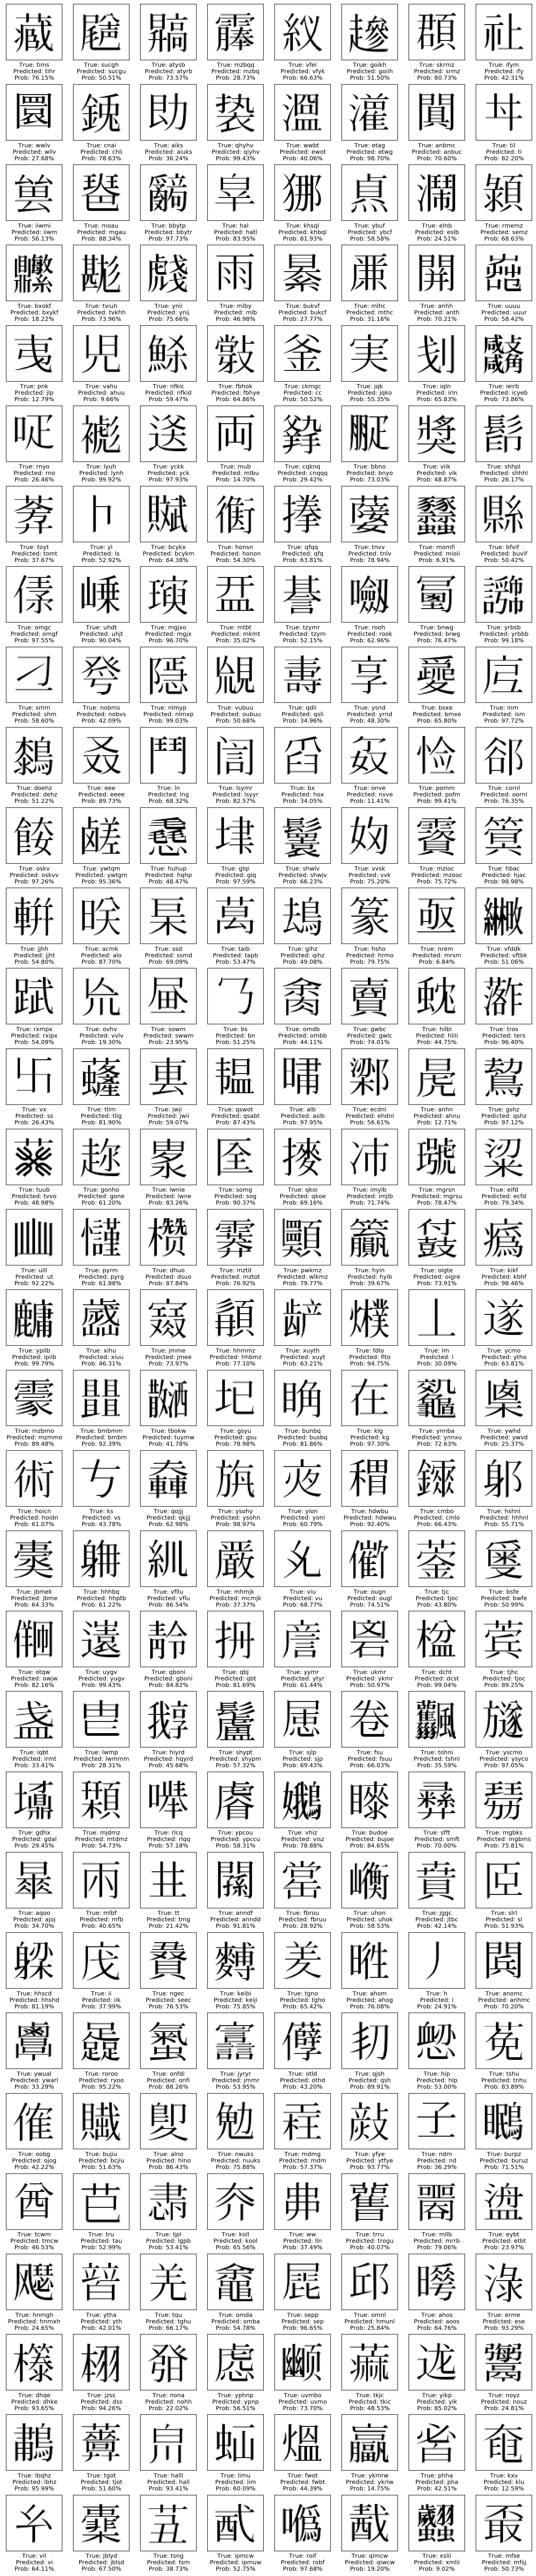

In [25]:
display_char(false_glyphs[:256], false_targets[:256], false_predicteds[:256], false_probs[:256])